In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from sklearn import linear_model
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time



GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'


num GPUs 0


# 1. Load a test image from a dataset (now : CelebA 128x128)

Dimensions of input image: (3, 128, 128)


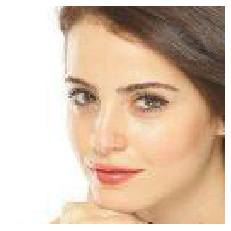

In [2]:
#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '1' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
if dataset == 'celeba':
    #img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64

    cx=89
    cy=121
    img_pil = img_pil.crop((cx-64, cy - 64, cx + 64, cy+64))

img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)

#img_np = (img_np- 1/2) *2 #convert to [-1,1] 

img_np_orig = 1*img_np

if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')
img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size

img_var = 2*img_var -1



# 2. Compressed sensing using generative models

## 2.1. Load a pretrained generative model on the dataset (now: PGGAN)

In [3]:
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)
G = model.netG
G.eval()

mse = torch.nn.MSELoss()


Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


## 2.2. A=I

In [7]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.1, lr_decay_epoch=100, factor=0.8):
    """Decay learning rate by a factor of 0.5 every lr_decay_epoch epochs."""
    lr = init_lr * (factor**(epoch // lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print('\nLR is set to {}'.format(lr))
        print('\n')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def fit(G, latentDim, y, num_iter = 1600, lr_decay_epoch = 400):
    G.eval()
    z = Variable(torch.normal(torch.zeros(1,latentDim)), requires_grad = True)
    optimizer = optim.Adam([z])
    for i in range(num_iter):
        #################
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.1, lr_decay_epoch=lr_decay_epoch, factor=0.7)
            
        #################
        def closure():
            optimizer.zero_grad()           
            #x = G(z)
            loss = mse(G(z), y)
            loss.backward(retain_graph=True)
            if i % 10 == 0:
                print('loss = {}'.format(loss))
            return loss

        loss = optimizer.step(closure)
    print('done')
    print('loss = {}'.format(loss))
    #print(z)
    return z


def CSGM(G, latentDim, y, x, device, num_iter=1800):
    G.eval()
    G.to(device)
    
    mse_wrt_truth = np.zeros(num_iter)
    
    objective = torch.nn.MSELoss()
    z_init = torch.normal(torch.zeros(1,latentDim)) #.to(config.device)

    z = torch.autograd.Variable(z_init, requires_grad = True)
    optimizer = torch.optim.Adam([{'params': z, 'lr': 0.1}])

    print('Running CSGM:')
    for i in range(num_iter):
        optimizer.zero_grad()
        Gz = G(z)
        #AGz = config.A(Gz)
        
        loss = objective(Gz, y)
        loss.backward()
        optimizer.step()
        if(i % 10 == 0):
            print('CSGM step %d/%d, objective = %.5f' %(i, num_iter, loss.item()))
        
        mse_wrt_truth[i] = mse(Gz,x).item()
    return z, mse_wrt_truth

def CSGM2(G, latentDim, y, x, A, device, num_iter=1600):
    G.eval()
    G.to(device)
    mse = torch.nn.MSELoss()
    z_init = torch.normal(torch.zeros(1,latentDim)).to(device)
    
    mse_wrt_truth = np.zeros(num_iter)

    z = torch.autograd.Variable(z_init, requires_grad = True)
    optimizer = torch.optim.Adam([{'params': Z, 'lr': 0.1}])
    
    print('Running CSGM:')
    for i in range(num_iter):
        optimizer.zero_grad()
        
        Gz = G(z)
        Gz_vec = Gz.reshape(Gz.numel())
        AGz = torch.matmul(A, Gz_vec) # TODO: try nonlinear measurement processes
        
        loss = mse(AGz, y)
        loss.backward()
        optimizer.step()
        
        if(i % 10 == 0):
            print('CSGM step %d/%d, objective = %.5f' %(i, num_iter, loss.item()))
        
        mse_wrt_truth[i] = mse(Gz,x).item()
        
    return z, mse_wrt_truth


In [11]:
print(torch.min(img_var), torch.max(img_var))

tensor(-0.9843) tensor(1.)


Running CSGM:
CSGM step 0/1600, objective = 0.97579
CSGM step 10/1600, objective = 0.11298
CSGM step 20/1600, objective = 0.06463
CSGM step 30/1600, objective = 0.04867
CSGM step 40/1600, objective = 0.04117
CSGM step 50/1600, objective = 0.03724
CSGM step 60/1600, objective = 0.03449
CSGM step 70/1600, objective = 0.03233
CSGM step 80/1600, objective = 0.03030
CSGM step 90/1600, objective = 0.02850
CSGM step 100/1600, objective = 0.02686
CSGM step 110/1600, objective = 0.02563
CSGM step 120/1600, objective = 0.02475
CSGM step 130/1600, objective = 0.02404
CSGM step 140/1600, objective = 0.02345
CSGM step 150/1600, objective = 0.02289
CSGM step 160/1600, objective = 0.02240
CSGM step 170/1600, objective = 0.02198
CSGM step 180/1600, objective = 0.02161
CSGM step 190/1600, objective = 0.02126
CSGM step 200/1600, objective = 0.02095
CSGM step 210/1600, objective = 0.02065
CSGM step 220/1600, objective = 0.02038
CSGM step 230/1600, objective = 0.02012
CSGM step 240/1600, objective = 0.019

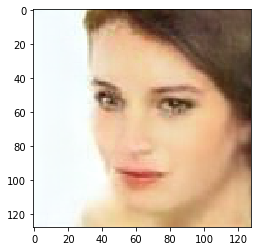

In [12]:
#z_hat = fit(G = G, latentDim = model.config.noiseVectorDim, y= img_var, num_iter = 1600, lr_decay_epoch = 400)    
z_hat,mse_wrt_truth = CSGM(G=G, 
             latentDim = model.config.noiseVectorDim, 
             y=img_var, 
             x=img_var,
             device = device,
             num_iter=1600)
gen_image = G(z_hat)

grid = torchvision.utils.make_grid(gen_image.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

plt.show()


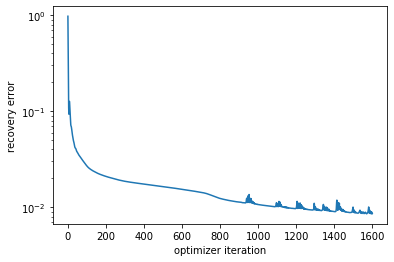

In [17]:
plt.xlabel('optimizer iteration')
plt.ylabel('recovery error')
plt.semilogy(mse_wrt_truth)

## 2.3. A= Gaussian 

In [ ]:
f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)


# random Gaussian measurement process

A = torch.randn(m_image, d_image).to(device)
x = img_var.to(device).reshape(d_image)
y = torch.matmul(A,x).to(device)



latentDim = model.config.noiseVectorDim

def fit2(G,A,y, d_image, latentDim, num_iter = 2000, lr_decay_epoch = 200):
    z = Variable(torch.randn(1,latentDim), requires_grad = True)
    
    optimizer = optim.Adam([z])
    for i in range(num_iter):
        ############
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.1, lr_decay_epoch = lr_decay_epoch, factor = 0.7)
        ############
        
        def closure():
            optimizer.zero_grad()
            
            x_var = G(z).reshape(d_image)
            y_var = torch.matmul(A,x_var)
            loss = mse(y_var, y)
            
            loss.backward(retain_graph = True)
            if i % lr_decay_epoch == 0:
                print('loss = {}'.format(loss))
            return loss
        
        loss = optimizer.step(closure)
    return z



In [ ]:
z = fit2(G, A, y, num_iter = 2000, lr_decay_epoch = 200)
x_hat = G(z)

#x_hat.reshape(x.size(0),x.size(1))
grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

# 4. Compressed Sensing using Deep decoder

## 4.1. Define the network

In [ ]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample


if dataset == 'mnist':
    num_channels = [25,15,10] 
elif dataset== 'celeba':    
    num_channels = [120,40,20,15,10] 
else:
    num_channels = [128,32,32]
    
output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, 
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)



In [ ]:
'''if decodetype=='upsample':
    p = [x for x in net.decoder.parameters() ] #list of all weigths
elif decodetype=='transposeconv':
    p = [x for x in net.convdecoder.parameters() ] #list of all weigths

weight_decay = 0
optimizer = torch.optim.Adam(p, lr=0.001 ,weight_decay=weight_decay)'''

## 4.2. A=I using untrained network

In [ ]:
def fit3(net, num_channels, d_image, y, A=1, num_iter = 2000, lr_decay_epoch = 500):
    # compute the size of (fixed) latent vector and draw it uniformly  
    totalupsample = 2**(len(num_channels)-1)
    w = np.sqrt(int(d_image/3)) # =d_image / out_channels = số chiều của mỗi cạnh ảnh
    width = int(w/(totalupsample))
    height = int(w/(totalupsample))

    shape = [1,num_channels[0], width, height]  
    print("shape of latent code B1: ", shape)

    print("initializing latent code B1...")
    net_input = Variable(torch.zeros(shape))
    net_input.data.uniform_()
    net_input.data *= 1./10

    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()

    #x_in = net(net_input.type(dtype)).data.clone() #initializing image

    # processing optimization
    if decodetype=='upsample':
        p = [x for x in net.decoder.parameters() ] #list of all weigths
    elif decodetype=='transposeconv':
        p = [x for x in net.convdecoder.parameters() ] #list of all weigths

    weight_decay = 0
    optimizer = torch.optim.Adam(p, lr=0.0001 ,weight_decay=weight_decay)
    mse = torch.nn.MSELoss()
    
    for i in range(num_iter):

        #################
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.0002, lr_decay_epoch=lr_decay_epoch,factor=0.8)

        #################
        def closure():
            optimizer.zero_grad()           
            x_hat = net(net_input.type(dtype))
            
            #y_hat = torch.matmul(A,x_hat.reshape(d_image))
            loss = mse(2*x_hat-1, y) #torch.matmul(A,x_hat)
            loss.backward()
            #mse_wrt_truth[i] = loss.data.cpu().numpy()
            return loss

        loss = optimizer.step(closure) 

        print ('Iteration %05d   Train loss %f ' % (i, loss.detach().cpu().numpy()), '\r', end='')

    return net, net_input, loss

In [ ]:
#img_var = 2*img_var -1 #convert image to [-1,1]


In [ ]:
net, net_input, loss = fit3(net, num_channels, d_image, y=img_var, num_iter = 12000, lr_decay_epoch=3000)
x_hat = net( net_input.type(dtype) )#.data.cpu().numpy()[0]

grid = torchvision.utils.make_grid(x_hat, scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

#plt.imshow(x_hat.transpose(1,2,0))
plt.show()

## 4.3. A=Gaussian using untrained network

# 5. Compressed sensing using hybrid model

## 5.1. Define hybrid model

In [ ]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample


if dataset == 'mnist':
    num_channels = [25,15,10] 
elif dataset== 'celeba':    
    num_channels = [120,40,20,15,10] 
else:
    num_channels = [128,64,32]
    
output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, 
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)

In [ ]:
def fit4(G, net, num_channels, d_image, y, z_0, latentDim, num_iter = 900, lr_decay_epoch = 0):
    G.eval()
    z = torch.normal(torch.zeros(1,latentDim)) #.to(config.device)
    z = Variable(z, requires_grad = True)
    
    
    # compute the size of (fixed) latent vector and draw it uniformly  
    totalupsample = 2**(len(num_channels)-1)
    w = np.sqrt(int(d_image/3)) # =d_image / out_channels = số chiều của mỗi cạnh ảnh
    width = int(w/(totalupsample))
    height = int(w/(totalupsample))

    shape = [1,num_channels[0], width, height]  
    print("shape of latent code B1: ", shape)

    print("initializing latent code B1...")
    net_input = Variable(torch.zeros(shape))
    net_input.data.uniform_()
    net_input.data *= 1./10

    net_input_saved = net_input.data.clone()
    noise = net_input.data.clone()
    
    # collecting all trainable parameters
    alpha = Variable(torch.ones(1), requires_grad=True)
    beta = Variable(torch.zeros(1), requires_grad=True)
    
    
    if decodetype=='upsample':
        p = [x for x in net.decoder.parameters() ] #list of all weigths
    elif decodetype=='transposeconv':
        p = [x for x in net.convdecoder.parameters() ] #list of all weigths
    
    
    
    #weight_decay = 0
    #optimizer = torch.optim.Adam(p, lr=0.001)
    
    optimizer = torch.optim.Adam(
    [
        {"params": p, "lr": 0.0001},
        {"params": alpha, "lr": 0.001},
        {"params": beta, "lr": 0.001},
        {"params": z, "lr": 0.1}
    ],
)
    
    mse = torch.nn.MSELoss()
    
    for i in range(num_iter):

        #################
        #if lr_decay_epoch is not 0:
        #    optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.001, lr_decay_epoch=lr_decay_epoch,factor=0.8)

        #################
        def closure():
            optimizer.zero_grad()           
            alpha_clamp = alpha.clamp(0,1)
            beta_clamp = beta.clamp(0,1)
            
            x_hat = alpha_clamp*G(z) + beta_clamp*net(net_input.type(dtype))
            y_hat = x_hat
            #y_hat = torch.matmul(A,x_hat.reshape(d_image))
            loss = mse(x_hat, y) #torch.matmul(A,x_hat)
            loss.backward()
            #mse_wrt_truth[i] = loss.data.cpu().numpy()
            return loss

        loss = optimizer.step(closure) 

        print ('Iteration %05d   Train loss %f ' % (i, loss.detach().cpu().numpy()), '\r', end='')

    return net, net_input, z, alpha, beta, loss

In [ ]:
img_var = 2*img_var -1

latentDim = model.config.noiseVectorDim
G.eval()
z0 = CSGM(G, latentDim, y=img_var, num_iter = 600)


z = torch.normal(torch.zeros(1,latentDim)) #.to(config.device)
z = Variable(z, requires_grad = True)


# compute the size of (fixed) latent vector and draw it uniformly  
totalupsample = 2**(len(num_channels)-1)
w = np.sqrt(int(d_image/3)) # =d_image / out_channels = số chiều của mỗi cạnh ảnh
width = int(w/(totalupsample))
height = int(w/(totalupsample))

shape = [1,num_channels[0], width, height]  
print("shape of latent code B1: ", shape)

print("initializing latent code B1...")
net_input = Variable(torch.zeros(shape))
net_input.data.uniform_()
net_input.data *= 1./20

net_input_saved = net_input.data.clone()
noise = net_input.data.clone()

# collecting all trainable parameters
alpha_init = torch.zeros(1)
beta_init = torch.zeros(1)
alpha_init.data[0] = 0.5
beta_init.data[0] = 0.5

alpha = Variable(alpha_init, requires_grad=True)
beta = Variable(beta_init, requires_grad=True)


if decodetype=='upsample':
    p = [x for x in net.decoder.parameters() ] #list of all weigths
elif decodetype=='transposeconv':
    p = [x for x in net.convdecoder.parameters() ] #list of all weigths



#weight_decay = 0
#optimizer = torch.optim.Adam(p, lr=0.001)

optimizer = torch.optim.Adam(
[
    {"params": p, "lr": 0.0001},
    {"params": alpha, "lr": 0.01},
    {"params": beta, "lr": 0.01},
    {"params": z, "lr": 0.1}
],
)

mse = torch.nn.MSELoss()

for i in range(1000):

    #################
    #if lr_decay_epoch is not 0:
    #    optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.001, lr_decay_epoch=lr_decay_epoch,factor=0.8)

    #################
    def closure():
        optimizer.zero_grad()           
        alpha_clamp = alpha.clamp(0,1).item()
        beta_clamp = beta.clamp(0,1).item()

        x_hat = alpha_clamp*G(z) + beta_clamp*(2*net(net_input.type(dtype))-1)
        y_hat = x_hat
        #y_hat = torch.matmul(A,x_hat.reshape(d_image))
        loss = mse(x_hat, img_var) #torch.matmul(A,x_hat)
        loss.backward()
        #mse_wrt_truth[i] = loss.data.cpu().numpy()
        return loss

    loss = optimizer.step(closure) 

    print ('Iteration %05d   Train loss %f ' % (i, loss.detach().cpu().numpy()), '\r', end='')


In [ ]:
print(alpha.clamp(0,1),beta.clamp(0,1))
print(torch.min(img_var), torch.max(img_var))

In [ ]:
x_hat = alpha.clamp(0,1)*G(z) + beta.clamp(0,1)*(2*net(net_input.type(dtype)) - 1)
x_hat_np = x_hat.data.cpu().numpy()[0]
grid = torchvision.utils.make_grid(img_var, scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
#plt.imshow(x_hat_np.transpose(1,2,0))
plt.show()


In [ ]:
A = torch.randn(2,3).to(device)

In [ ]:
print(A)